## <span style="color:#730101">Classification of Review Stars</span>

In this entity, we apply 4 different models and take several evaluation metrics and plots. Finally, we choose the best model according to the metrics.

##### <span style="color:#3A3A3A">Import Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import random


from itertools import cycle
from typing import List, Tuple
from scipy import interp
from typing import Tuple, List
from glob import glob
from sklearn.metrics import 
from math import sqrt

from tqdm import tqdm
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models, regularizers
from tensorflow.python.keras.layers import Embedding, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Activation, Dropout, BatchNormalization , SpatialDropout1D , Bidirectional , GRU
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D , GlobalAveragePooling1D , concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding , LSTM, Dropout, Activation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_absolute_error, mean_squared_error

In [2]:
pd.options.mode.chained_assignment = None
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

##### <span style="color:#3A3A3A">Import Datasets</span>

In [3]:
# Import Train Datasets
X_train = np.load("X_train.npy",allow_pickle=True)
Y_train = np.load("Y_train.npy")
assert X_train.shape[0]==Y_train.shape[0]

# Import Test Datasets
X_test = np.load("X_test.npy",allow_pickle=True)
Y_test = np.load("Y_test.npy")
assert X_test.shape[0]==Y_test.shape[0]

In [4]:
# Import Tokenizers
with open('x_train_tokenizer.pkl', 'rb') as train:
    x_train_tokenizer = pickle.load(train)

##### <span style="color:#3A3A3A">Data Pre-Processing</span>

In [5]:
# Transform the Y variable in Binary Labels to better distinct the classes of the variable
lb = preprocessing.LabelBinarizer()

Y_train = lb.fit_transform(Y_train)
Y_test = lb.fit_transform(Y_test)

n_classes = Y_train.shape[1]
n_classes  # number of classes for ratings

5

In [6]:
X_train.shape,Y_train.shape

((811035, 84), (811035, 5))

In [7]:
X_test.shape , Y_test.shape

((202759, 84), (202759, 5))

##### <span style="color:#3A3A3A">Definitions of the Evaluation Plots</span>

Function to plot the ROC Curve and Estimate the Area under the Curve.

In [8]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()   
   
    for i in  range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue',
                    'red',
                    'limegreen'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)

    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue',
                    'red',
                    'limegreen'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--', lw=lw)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()


Function to plot the History of every Model.

In [9]:
%matplotlib inline

def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

### <span style="color:#F2583E">Multi-Class Classification of Yelp Ratings from Review and Categories Text</span>

#### <span style="color:#3A3A3A"> Model with pre-trained embeddings (GLOVE)</span>

In [10]:
def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname , encoding= "utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [11]:
embedding_dim = 300  # We now use larger embeddings

embeddings_index = load_glove_embeddings(dim=embedding_dim)

Loading Embeddings: 1215word [00:00, 12095.36word/s]

Loading word vectors


Loading Embeddings: 400000word [00:33, 12028.52word/s]

Found 400000 word vectors.


In [12]:
embeddings_index['food']

array([ 3.8544e-01,  3.4247e-01,  2.9599e-01, -2.6200e-01,  3.7383e-02,
        4.5544e-01,  4.9097e-01,  1.1481e-01, -1.1437e-01, -1.9067e+00,
        3.5563e-02, -1.1094e+00, -2.6512e-01,  6.4418e-01, -3.1008e-02,
       -3.5130e-01, -1.0547e-03,  7.4658e-02, -3.0369e-01, -2.8188e-01,
       -3.4342e-01,  3.6205e-01,  7.1009e-01,  3.0243e-01,  7.0325e-02,
        2.9492e-01, -1.6233e-01,  3.0998e-01,  1.3705e-01,  1.1847e-01,
       -6.8642e-01,  4.3305e-01, -6.1518e-01,  2.3643e-01, -8.4174e-01,
        1.4667e-01, -9.6616e-02, -2.0908e-01, -4.2296e-01, -2.7254e-01,
       -7.9343e-01, -6.2781e-01,  6.4804e-01,  1.1541e-01, -3.3486e-01,
       -1.4101e-01,  1.2864e-01, -2.5123e-01, -2.6515e-01,  3.0876e-01,
       -6.3111e-02,  1.7893e-01,  4.1197e-01,  1.9621e-02, -1.5406e-01,
        1.7542e-01,  3.9268e-01,  8.8817e-02,  1.8012e-02, -2.2508e-01,
       -3.1832e-01,  2.2296e-02,  5.9453e-01,  5.6538e-02, -7.2464e-01,
       -3.1751e-01, -3.8650e-01,  3.3806e-01, -1.6237e-01, -7.61

In [13]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: x_train_tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index
    
    max_words = len(word_index)

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [14]:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=x_train_tokenizer,
                                            emb_dim=embedding_dim)

D:\Users\billk\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: -0.003905011573806405 | STD: 0.3817702829837799
Found 27041 pre-trained embeddings out of 33434


In [15]:
callbacks = [
        
    EarlyStopping(monitor='val_loss',
                  patience=3,
                  verbose=1,
                  restore_best_weights=True),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.1,
                      patience=2,
                      verbose=1,
                      min_delta = 0.001)

]

In [16]:
# Define a sequential Model
glove_model = Sequential()
# Keep the word index of the tokenizer
word_index = x_train_tokenizer.word_index
# Keep the max words
max_words = len(word_index)
# Take the number of rows of the x train dataset
text_shape = X_train.shape[1]

# We start off with an efficient embedding layer which maps
# our vocabulary indices into embedding dimensions
glove_model.add(Embedding(max_words,
                          embedding_dim,
                          input_length = text_shape,
                          weights=[embedding_matrix],
                          trainable=False))

# we add a Convolution1D, which will learn filters
# word group filters of size 64
glove_model.add(Conv1D(64, 5, activation='relu'))

# We use max pooling
glove_model.add(MaxPooling1D(3))

#Add an lstm layer to the model
glove_model.add(LSTM(50, activation="tanh", return_sequences=True))

# We use global max pooling
glove_model.add(GlobalMaxPooling1D())

# Since we have a multiclass classification scheme, we selece 5 neurons with softmax activation.
glove_model.add(Dense(Y_train.shape[1], activation='softmax'))

# Compile using Adam Optimiser and Categorical Crossentropy
glove_model.compile(loss = 'categorical_crossentropy', 
                    optimizer = 'adam', 
                    metrics = ['accuracy'])

glove_model._name="Glove_model"

# Print the summary of the Model
glove_model.summary()

Model: "Glove_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 84, 300)           10030200  
_________________________________________________________________
conv1d (Conv1D)              (None, 80, 64)            96064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 26, 50)            23000     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 255       
Total params: 10,149,519
Trainable params: 119,319
Non-trainable params: 10,030,200
_____________________________________

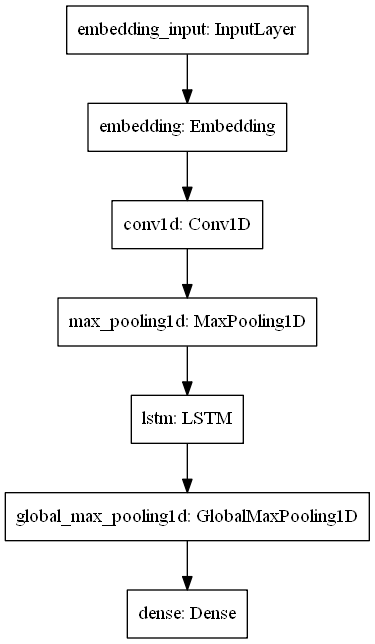

In [2]:
# Plot the layers of the model
tf.keras.utils.plot_model(glove_model, to_file='glove_model.png')

In [17]:
random.seed(123)

# We train (fit our data to) our model
history_glove_model = glove_model.fit(X_train,
                                      Y_train ,
                                      batch_size = 64 ,
                                      verbose = 1, 
                                      epochs = 20 , 
                                      validation_split=0.20, 
                                      callbacks=callbacks)

Epoch 1/20
10138/10138 [==============================] - 296s 29ms/step - loss: 0.8569 - accuracy: 0.6362 - val_loss: 0.8162 - val_accuracy: 0.6535
Epoch 2/20
10138/10138 [==============================] - 292s 29ms/step - loss: 0.8046 - accuracy: 0.6576 - val_loss: 0.8061 - val_accuracy: 0.6577
Epoch 3/20
10138/10138 [==============================] - 311s 31ms/step - loss: 0.7851 - accuracy: 0.6655 - val_loss: 0.8046 - val_accuracy: 0.6580
Epoch 4/20
10138/10138 [==============================] - 311s 31ms/step - loss: 0.7716 - accuracy: 0.6713 - val_loss: 0.8025 - val_accuracy: 0.6600
Epoch 5/20
10138/10138 [==============================] - 301s 30ms/step - loss: 0.7614 - accuracy: 0.6756 - val_loss: 0.8054 - val_accuracy: 0.6599
Epoch 6/20
10138/10138 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.6791
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
10138/10138 [==============================] - 301s 30ms/step - loss: 0.75

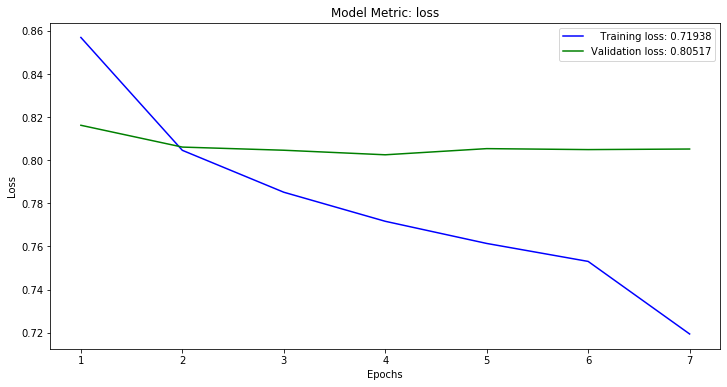

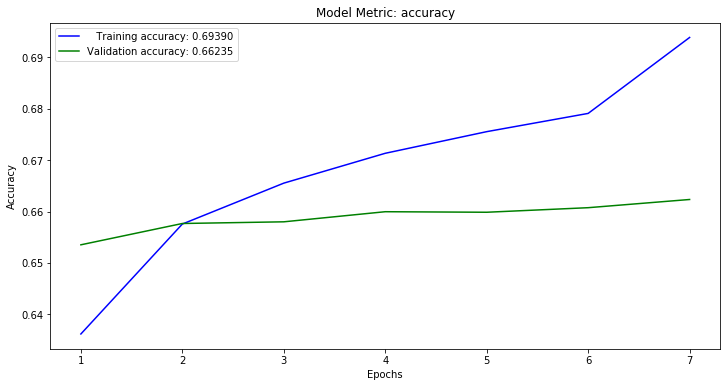

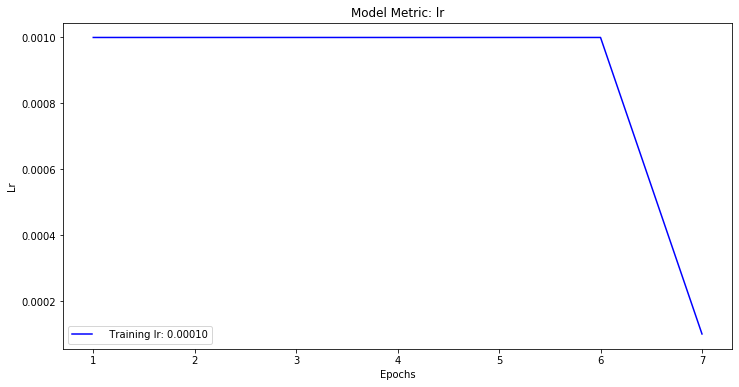

In [18]:
# Plot Model
plot_keras_history(history_glove_model)

In [19]:
# Check the number of the iterations per epoch wich depends on Validation split and batch size
X_train.shape[0]*0.8//64  

10137.0

In [20]:
# Save Model
glove_model.save(os.path.join(os.getcwd(), 'Glove_model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\billk\Dropbox\Content Analytics\assignment\Final\Glove_model\assets


In [8]:
# Calculate the predicted y on the X test
y_pred_glove = glove_model.predict(X_test)
y_pred_glove.shape

(202759, 5)

In [9]:
round(mean_absolute_error(Y_test, y_pred_glove),3)

0.175

In [33]:
round(sqrt(mean_squared_error(Y_test, y_pred_glove)),3)

0.299

In [10]:
# We will use the accuracy on the Test set to select the best model
accuracy_test_glove = glove_model.evaluate(X_test, Y_test)

6337/6337 [==============================] - 119s 19ms/step - loss: 0.8052 - accuracy: 0.6573


In [11]:
# Table of the Confusion Matrix
class_names=['1', '2', '3', '4', '5']
conf_mat = confusion_matrix(Y_test.argmax(axis=1),y_pred_glove.argmax(axis=1))
conf_matrix_glove=pd.DataFrame(conf_mat, columns=class_names,index=class_names)
conf_matrix_glove

,1,2,3,4,5
1,18437,2252,1428,300,904
2,5685,3847,4502,939,1082
3,2098,2142,8679,6095,3564
4,629,338,4419,16810,23116
5,683,108,1174,8033,85495


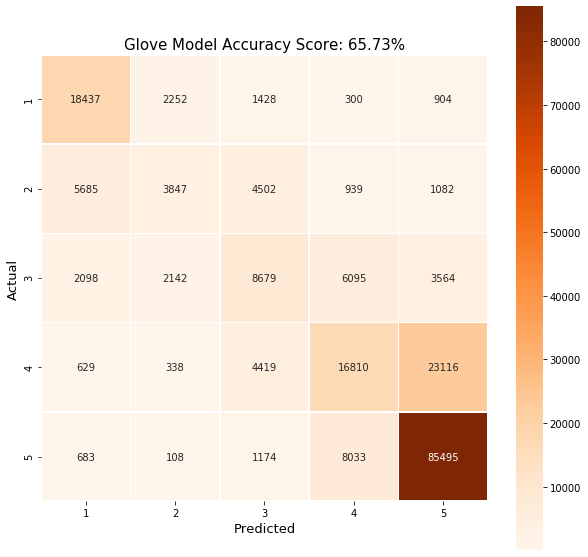

In [13]:
# Plot the confusion Matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_glove, annot=True, fmt='d',linewidths=.5, cmap="Oranges", square = True,
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual', size = 13)
plt.xlabel('Predicted', size = 13)
all_sample_title = 'Glove Model Accuracy Score: 65.73%'
plt.title(all_sample_title, size = 15);
#plt.savefig("glove_conf_matrix.png")
plt.show()

In [28]:
# Create the Classification Report
print("Classification report for Glove Model classifier : ")
print(classification_report(Y_test.argmax(axis=1), y_pred_glove.argmax(axis=1), target_names=class_names))

Classification report for Glove Model classifier : 
              precision    recall  f1-score   support

           1       0.67      0.79      0.73     23321
           2       0.44      0.24      0.31     16055
           3       0.43      0.38      0.41     22578
           4       0.52      0.37      0.43     45312
           5       0.75      0.90      0.82     95493

    accuracy                           0.66    202759
   macro avg       0.56      0.54      0.54    202759
weighted avg       0.63      0.66      0.63    202759



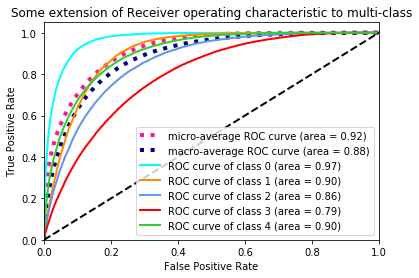

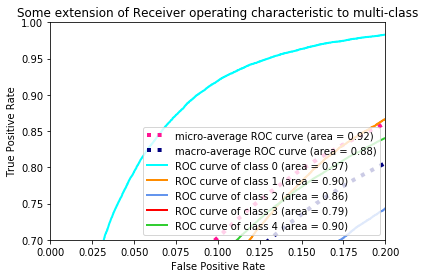

In [29]:
# Plot the ROC Curves in order to calculate the Area Under the Curve
plot_multi_class_roc_auc_curves(nb_classes=5,
                                y_true=Y_test,
                                y_pred_score=y_pred_glove)

#### <span style="color:#3A3A3A"> MLP Model with pre-trained embeddings (FastText)</span>

In [30]:
def load_fasttext_embeddings(dim: int = 300) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')
    
    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'wiki-news-300d-1M.vec'.format(dim)
    
    # Open file
    f = open(fname, 'r', encoding='utf-8')
    
    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [31]:
embedding_dim = 300  

embeddings_index = load_fasttext_embeddings(dim=embedding_dim)

Loading Embeddings: 1278word [00:00, 12610.29word/s]

Loading word vectors


Loading Embeddings: 999995word [01:26, 11539.15word/s]

Found 999995 word vectors.


In [32]:
len(list(embeddings_index.values()))

999995

In [33]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: x_train_tokenizer,
                             emb_dim: int = 300) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(list(emb_index.values())[1:len(list(embeddings_index.values()))])  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index
    
    max_words = len(word_index)

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [34]:
embedding_matrix= create_embeddings_matrix(emb_index = embeddings_index,
                                            tokenizer = x_train_tokenizer,
                                            emb_dim = embedding_dim)

Embeddings AVG: -0.0033469984773546457 | STD: 0.10985549539327621
Found 27354 pre-trained embeddings out of 33434


In [35]:
callbacks = [
        
    EarlyStopping(monitor='val_loss',
                  patience=3,
                  verbose=1,
                  restore_best_weights=True),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.1,
                      patience=1,
                      verbose=1,
                      min_delta = 0.001)

]

In [36]:
# Define the size of our vocabulary
vocab_size = len(x_train_tokenizer.word_index)
# Define Embedding Dimension
embedding_dim = 300
# Take the number of rows of the x train dataset
text_shape = X_train.shape[1] 

# Define a Sequential Model
fasttext_model = Sequential()    

# We start off with an efficient embedding layer which maps
# our vocabulary indices into embedding dimensions
fasttext_model.add(Embedding(input_dim = vocab_size,
                             output_dim =e mbedding_dim,
                             input_length = text_shape,
                             weights = [embedding_matrix],
                             trainable = False))

fasttext_model.add(Flatten())
# Add a Dense Layer 
fasttext_model.add(Dense(32, 
                    activation='relu'))

# Since we have a multiclass classification scheme, we selece 5 neurons with softmax activation.
fasttext_model.add(Dense(Y_train.shape[1], 
                         activation='softmax'))

fasttext_model._name = "Fast_Text_Model"

# Print the summary of the Model
print(fasttext_model.summary())

# Compile using Adam Optimiser and Categorical Crossentropy
fasttext_model.compile(optimizer= 'Adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

Model: "Fast_Text_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 84, 300)           10030200  
_________________________________________________________________
flatten (Flatten)            (None, 25200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                806432    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 10,836,797
Trainable params: 806,597
Non-trainable params: 10,030,200
_________________________________________________________________
None


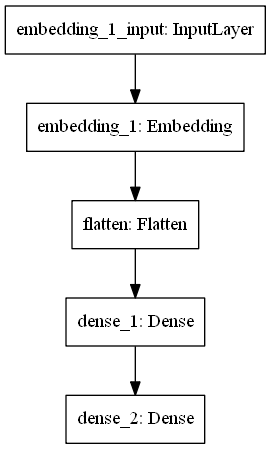

In [3]:
# Plot the layers of the model
tf.keras.utils.plot_model(fasttext_model, to_file='Fast_Text_Model.png')

In [37]:
random.seed(123)

# We train (fit our data to) our model
fasttext_model_history = fasttext_model.fit(X_train, 
                                            Y_train,
                                            epochs = 20,
                                            verbose = 1,
                                            batch_size = 64,
                                            validation_split = 0.2,
                                            callbacks = callbacks)

Epoch 1/20
10138/10138 [==============================] - 75s 7ms/step - loss: 1.0013 - accuracy: 0.5845 - val_loss: 0.9576 - val_accuracy: 0.6007
Epoch 2/20
10138/10138 [==============================] - 74s 7ms/step - loss: 0.9283 - accuracy: 0.6109 - val_loss: 0.9250 - val_accuracy: 0.6106
Epoch 3/20
10138/10138 [==============================] - 72s 7ms/step - loss: 0.9134 - accuracy: 0.6159 - val_loss: 0.9224 - val_accuracy: 0.6139
Epoch 4/20
10138/10138 [==============================] - 70s 7ms/step - loss: 0.9052 - accuracy: 0.6198 - val_loss: 0.9163 - val_accuracy: 0.6157
Epoch 5/20
10136/10138 [============================>.] - ETA: 0s - loss: 0.8996 - accuracy: 0.6217
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
10138/10138 [==============================] - 69s 7ms/step - loss: 0.8997 - accuracy: 0.6217 - val_loss: 0.9320 - val_accuracy: 0.6098
Epoch 6/20
10138/10138 [==============================] - 70s 7ms/step - loss: 0.8742 - accurac

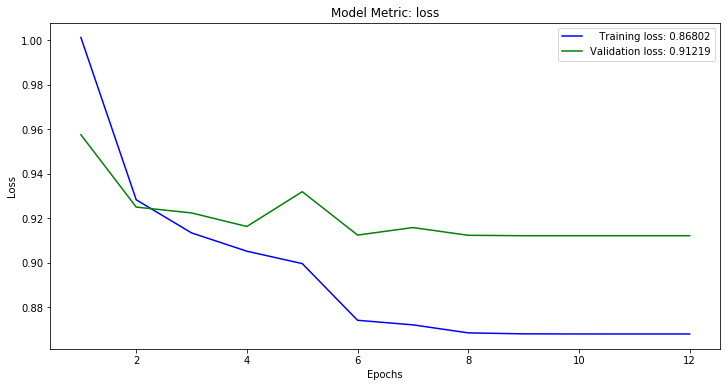

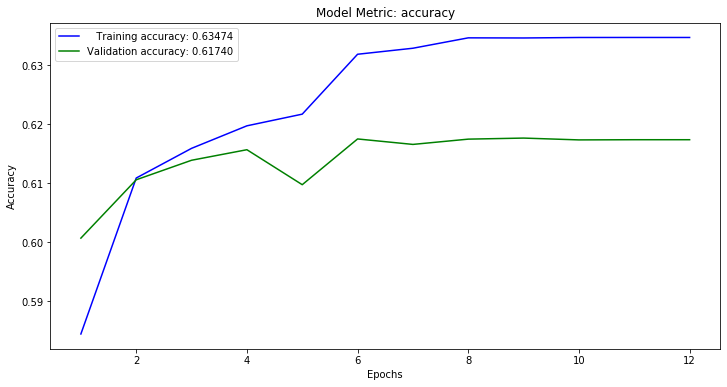

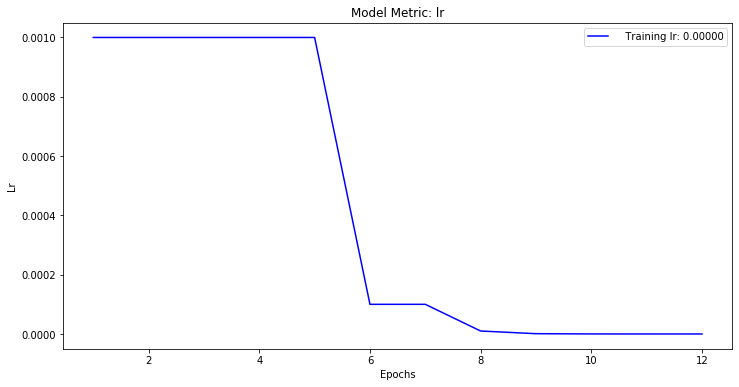

In [38]:
# Plot Model
plot_keras_history(fasttext_model_history)

In [39]:
# Save Model
fasttext_model.save(os.path.join(os.getcwd(), 'Fast_Text_Model'))

INFO:tensorflow:Assets written to: C:\Users\billk\Dropbox\Content Analytics\assignment\Final\Fast_Text_Model\assets


In [14]:
# Calculate the predicted y on the X test
y_pred_fasttext = fasttext_model.predict(X_test)

In [15]:
round(mean_absolute_error(Y_test, y_pred_fasttext),3)

0.194

In [34]:
round(sqrt(mean_squared_error(Y_test, y_pred_fasttext)),3)

0.314

In [16]:
# We will use the accuracy on the Test set to select the best model
accuracy_test_fasttext = fasttext_model.evaluate(X_test, Y_test)

6337/6337 [==============================] - 37s 6ms/step - loss: 0.9150 - accuracy: 0.6151


In [17]:
# Table of the Confusion Matrix
class_names=['1', '2', '3', '4', '5']
conf_mat = confusion_matrix(Y_test.argmax(axis=1),y_pred_fasttext.argmax(axis=1))
conf_matrix_fasttext=pd.DataFrame(conf_mat, columns=class_names,index=class_names)
conf_matrix_fasttext

,1,2,3,4,5
1,17815,2209,1284,361,1652
2,6183,3069,3358,1436,2009
3,2701,2343,5851,6287,5396
4,1041,963,4342,14256,24710
5,1209,404,1514,8635,83731


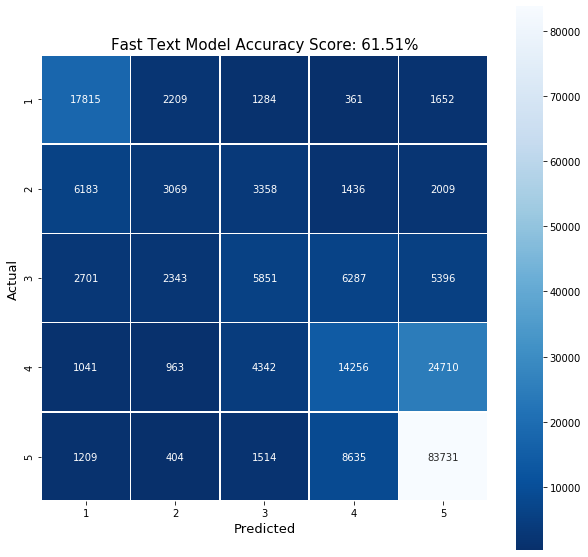

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_fasttext, annot=True, fmt='d',linewidths=.5, cmap="Blues_r", square = True,
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual', size = 13)
plt.xlabel('Predicted', size = 13)
all_sample_title = 'Fast Text Model Accuracy Score: 61.51%'
plt.title(all_sample_title, size = 15);
#plt.savefig("fasttext_conf_matrix.png")
plt.show()

In [46]:
# Create the Classification Report
print("Classification report for FastText Model classifier : ")
print(classification_report(Y_test.argmax(axis=1), y_pred_fasttext.argmax(axis=1), target_names=class_names))

Classification report for FastText Model classifier : 
              precision    recall  f1-score   support

           1       0.62      0.76      0.68     23321
           2       0.34      0.19      0.25     16055
           3       0.36      0.26      0.30     22578
           4       0.46      0.31      0.37     45312
           5       0.71      0.88      0.79     95493

    accuracy                           0.62    202759
   macro avg       0.50      0.48      0.48    202759
weighted avg       0.58      0.62      0.59    202759



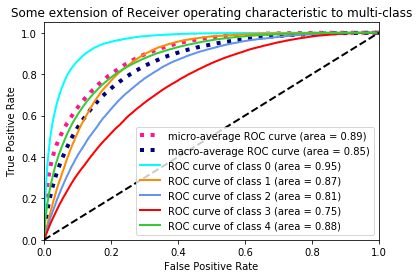

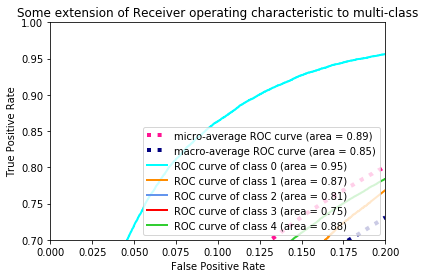

In [47]:
# Plot the ROC Curves in order to calculate the Area Under the Curve
plot_multi_class_roc_auc_curves(nb_classes=5,
                                y_true=Y_test,
                                y_pred_score=y_pred_fasttext)

#### <span style="color:#3A3A3A"> Model  with Self-Trained Embeddings</span>

In [48]:
# Take the number of rows of the x train dataset
text_shape = X_train.shape[1] 
# Define the size of our vocabulary
vocab_size_text = len(x_train_tokenizer.word_index)

# Define a sequential Model
self_trained_model = Sequential()

# Define the Input Layer of the Model
text_input = keras.Input(shape=(text_shape,), name='text_input')

# Build the Embedding Layer
text_embeddings = layers.Embedding(input_dim = vocab_size_text, 
                                   output_dim = 300,
                                   input_length = text_shape,
                                   mask_zero = True,
                                   name="text_embedding_layer")(text_input)

# We use global max pooling
encoded_text_layer = layers.GlobalMaxPooling1D(name="globalmaxpooling_text_Layer")(text_embeddings)

# A low-dimensional space may be too limited to learn to separate so many different classes: such small layers may act as 
# information bottlenecks, permanently dropping relevant information. For this reason we’ll use larger layers. 
dense_layer_1 = layers.Dense(64,
                             activation = "relu",
                             kernel_regularizer = regularizers.l2(0.01),
                             name = "1st_dense_hidden_layer")
x = dense_layer_1(encoded_text_layer)

# 10% of the neurons will receive a zero weight. This operation controls the regularization process and helps in 
# preventing over-fitting.
x = layers.Dropout(0.1)(x) 

# Since we have a multiclass classification scheme, we selece 5 neurons with softmax activation.
outputs = layers.Dense(Y_train.shape[1], #number of labels in classification
                       activation = 'softmax',
                       name = 'output_layer')(x)

In [49]:
# Define the Keras Model
self_trained_model = keras.Model(inputs = text_input, 
                                 outputs = outputs, 
                                 name = "self_trained_model")

# Use Adam Optimiser
model_optimiser = keras.optimizers.Adam(learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07,
                                        amsgrad=False,
                                        name="Adam")

# Print the summary of the Model
print(self_trained_model.summary())

# Compile using Adam Optimiser and Categorical Crossentropy
self_trained_model.compile(loss = 'categorical_crossentropy',
                           optimizer = model_optimiser,
                           metrics = ["accuracy"])

Model: "self_trained_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 84)]              0         
_________________________________________________________________
text_embedding_layer (Embedd (None, 84, 300)           10030200  
_________________________________________________________________
globalmaxpooling_text_Layer  (None, 300)               0         
_________________________________________________________________
1st_dense_hidden_layer (Dens (None, 64)                19264     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 10,049,789
Trainable params: 10,049,789
Non-trainable params: 0
____________________________________

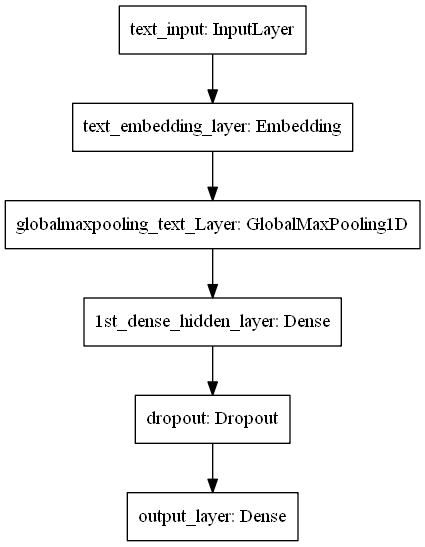

In [4]:
# Plot the layers of the model
tf.keras.utils.plot_model(self_trained_model, to_file='Self_Trained_Model.png')

In [50]:
monitor = 'val_loss'

callbacks = [
        
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  min_delta=0.01,
                  patience=3,
                  verbose=1,
                  restore_best_weights=True),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=2,
                      verbose=1)
]

In [51]:
random.seed(123)

# We train (fit our data to) our model
self_trained_model_history = self_trained_model.fit(X_train,
                                                    Y_train,
                                                    epochs = 20,
                                                    batch_size = 64,
                                                    callbacks = callbacks,
                                                    verbose = 1,
                                                    validation_split = 0.2 # 80% for train and 20% for validation
)

Epoch 1/20
10138/10138 [==============================] - 1521s 150ms/step - loss: 0.9046 - accuracy: 0.6298 - val_loss: 0.8812 - val_accuracy: 0.6341
Epoch 2/20
10138/10138 [==============================] - 1519s 150ms/step - loss: 0.8466 - accuracy: 0.6489 - val_loss: 0.8461 - val_accuracy: 0.6495
Epoch 3/20
10138/10138 [==============================] - 1524s 150ms/step - loss: 0.8300 - accuracy: 0.6562 - val_loss: 0.8462 - val_accuracy: 0.6485
Epoch 4/20
10138/10138 [==============================] - ETA: 0s - loss: 0.8171 - accuracy: 0.6625
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
10138/10138 [==============================] - 1525s 150ms/step - loss: 0.8171 - accuracy: 0.6625 - val_loss: 0.8502 - val_accuracy: 0.6520
Epoch 5/20
10138/10138 [==============================] - 1525s 150ms/step - loss: 0.7688 - accuracy: 0.6823 - val_loss: 0.8272 - val_accuracy: 0.6547
Epoch 6/20
10138/10138 [==============================] - 1525s 150ms/step 

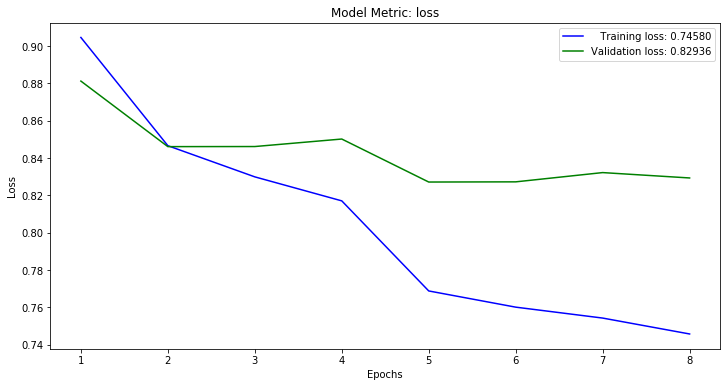

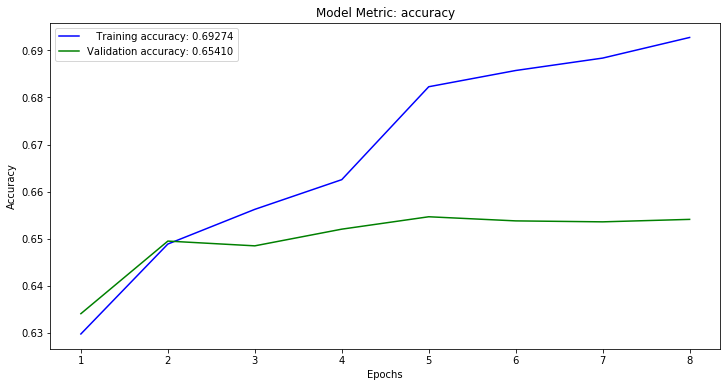

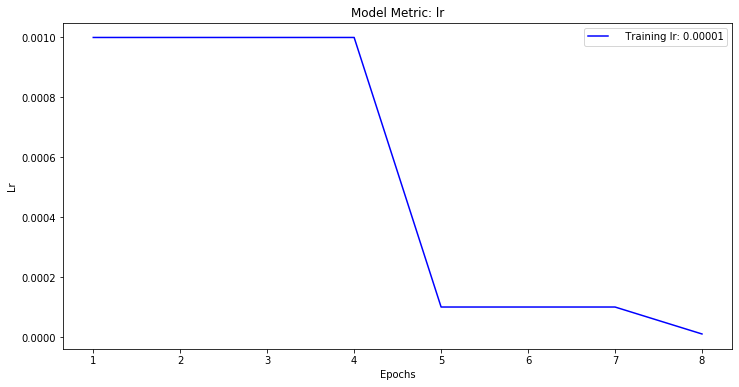

In [52]:
# Plot Model
plot_keras_history(self_trained_model_history)

In [54]:
# Save Model
self_trained_model.save(os.path.join(os.getcwd(), 'Self_Trained_Model'))

INFO:tensorflow:Assets written to: C:\Users\billk\Dropbox\Content Analytics\assignment\Final\Self_Trained_Model\assets


In [20]:
# Calculate the predicted y on the X test
y_pred_my_model = self_trained_model.predict(X_test)

In [21]:
round(mean_absolute_error(Y_test, y_pred_my_model),3)

0.177

In [35]:
round(sqrt(mean_squared_error(Y_test, y_pred_my_model)),3)

0.3

In [22]:
# We will use the accuracy on the Test set to select the best model
accuracy_test_mymodel = self_trained_model.evaluate(X_test, Y_test)

6337/6337 [==============================] - 34s 5ms/step - loss: 0.8298 - accuracy: 0.6524


In [24]:
# Table of the Confusion Matrix
class_names=['1', '2', '3', '4', '5']
conf_mat = confusion_matrix(Y_test.argmax(axis=1),y_pred_my_model.argmax(axis=1))
conf_matrix_mymodel=pd.DataFrame(conf_mat, columns=class_names,index=class_names)
conf_matrix_mymodel

,1,2,3,4,5
1,18590,2356,1344,269,762
2,5780,4055,4220,1125,875
3,2093,2503,8315,6705,2962
4,607,490,4687,18944,20584
5,677,151,1380,10912,82373


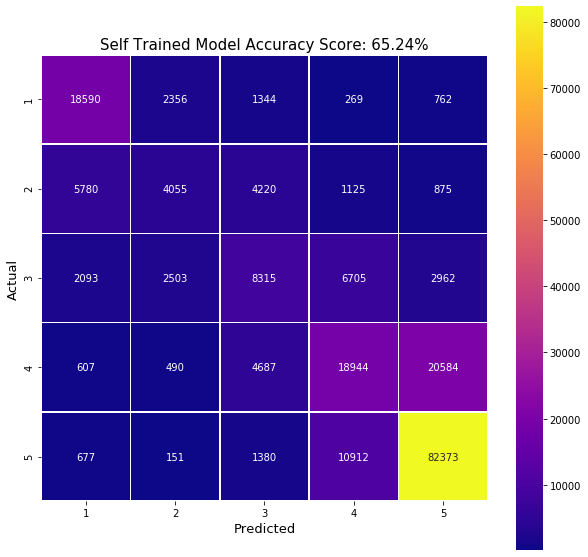

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_mymodel, annot=True, fmt='d',linewidths=.5, cmap="plasma", square = True,
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual', size = 13)
plt.xlabel('Predicted', size = 13)
all_sample_title = 'Self Trained Model Accuracy Score: 65.24%'
plt.title(all_sample_title, size = 15);
#plt.savefig("my_model_conf_matrix.png")
plt.show()

In [61]:
# Create the Classification Report
print("Classification report for Self Trained Model classifier : ")
print(classification_report(Y_test.argmax(axis=1), y_pred_my_model.argmax(axis=1), target_names=class_names))

Classification report for Self Trained Model classifier : 
              precision    recall  f1-score   support

           1       0.67      0.80      0.73     23321
           2       0.42      0.25      0.32     16055
           3       0.42      0.37      0.39     22578
           4       0.50      0.42      0.46     45312
           5       0.77      0.86      0.81     95493

    accuracy                           0.65    202759
   macro avg       0.56      0.54      0.54    202759
weighted avg       0.63      0.65      0.64    202759



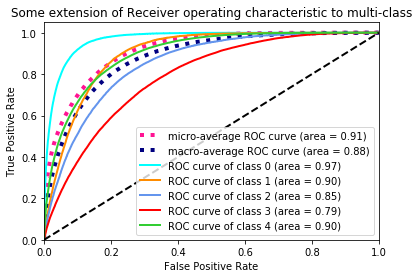

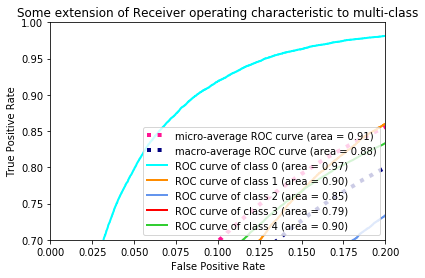

In [62]:
# Plot the ROC Curves in order to calculate the Area Under the Curve
plot_multi_class_roc_auc_curves(nb_classes=5,
                                y_true=Y_test,
                                y_pred_score=y_pred_my_model)

#### <span style="color:#3A3A3A"> CNN  with Self-Trained Embeddings</span>

In [63]:
# Take the number of rows of the x train dataset
text_shape = X_train.shape[1] 

# Define the size of our vocabulary
vocab_size_text = len(x_train_tokenizer.word_index)

# Define the Input Layer of the Model
text_input = keras.Input(shape=(text_shape,), name='text_input')

# Build the Embedding Layer
text_embeddings = layers.Embedding(input_dim = vocab_size_text, 
                                   output_dim = 300,
                                   input_length = text_shape,
                                   trainable=True,
                                   name="text_embedding_layer")(text_input)

dense_layer_1 = layers.Conv1D(64,
                              3,
                              activation = "relu",
                              name = "1st_dense_hidden_layer")

x = dense_layer_1(text_embeddings)
# We use global max pooling
x = layers.GlobalMaxPooling1D()(x)

# 10% of the neurons will receive a zero weight. This operation controls the regularization process and helps in 
# preventing over-fitting.
x = layers.Dropout(0.1)(x) 

# Since we have a multiclass classification scheme, we selece 5 neurons with softmax activation.
outputs = layers.Dense(Y_train.shape[1], #number of labels in classification
                       activation='softmax',
                       name='output_layer')(x)

In [64]:
# Use Adam Optimiser
model_optimiser = keras.optimizers.Adam(learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-07,
                                        amsgrad=False,
                                        name="Adam")

# Define the Keras Model
self_trained_model_cnn = keras.Model(inputs = text_input, 
                                     outputs = outputs, 
                                     name = "my_model_cnn")
# Print the summary of the Model
print(self_trained_model_cnn.summary())

# Compile using Adam Optimiser and Categorical Crossentropy
self_trained_model_cnn.compile(loss = 'categorical_crossentropy',
                               optimizer = model_optimiser,
                               metrics = ["accuracy"])

Model: "my_model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 84)]              0         
_________________________________________________________________
text_embedding_layer (Embedd (None, 84, 300)           10030200  
_________________________________________________________________
1st_dense_hidden_layer (Conv (None, 82, 64)            57664     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 10,088,189
Trainable params: 10,088,189
Non-trainable params: 0
__________________________________________

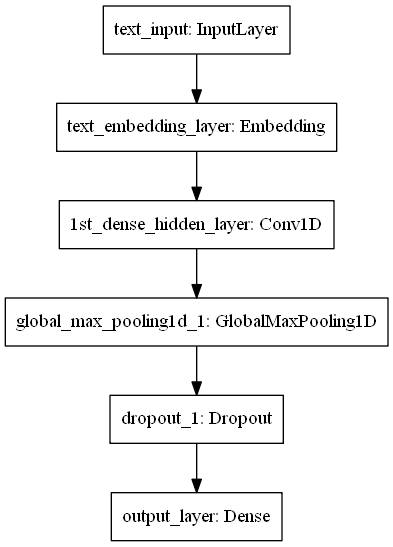

In [5]:
# Plot the layers of the model
tf.keras.utils.plot_model(self_trained_model_cnn, to_file='Self_Trained_Model_CNN.png')

In [65]:
monitor = 'val_loss'

callbacks = [
        
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=3,
                  verbose=1,
                  restore_best_weights=True),

    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=2,
                      verbose=1)

]

In [66]:
random.seed(123)

# We train (fit our data to) our model
self_trained_model_cnn_history = self_trained_model_cnn.fit(X_train,
                                                            Y_train,
                                                            epochs = 20,
                                                            batch_size = 64,
                                                            callbacks = callbacks,
                                                            verbose = 1,
                                                            validation_split = 0.2  # 80% for train and 20% for validation
)

Epoch 1/20
10138/10138 [==============================] - 1659s 164ms/step - loss: 0.8493 - accuracy: 0.6402 - val_loss: 0.7991 - val_accuracy: 0.6607
Epoch 2/20
10138/10138 [==============================] - 1658s 164ms/step - loss: 0.7894 - accuracy: 0.6651 - val_loss: 0.7978 - val_accuracy: 0.6608
Epoch 3/20
10138/10138 [==============================] - 1655s 163ms/step - loss: 0.7535 - accuracy: 0.6816 - val_loss: 0.8046 - val_accuracy: 0.6586
Epoch 4/20
10138/10138 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.6974
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
10138/10138 [==============================] - 1656s 163ms/step - loss: 0.7197 - accuracy: 0.6974 - val_loss: 0.8166 - val_accuracy: 0.6571
Epoch 5/20
10138/10138 [==============================] - 1653s 163ms/step - loss: 0.6430 - accuracy: 0.7335 - val_loss: 0.8290 - val_accuracy: 0.6573
Epoch 00005: early stopping


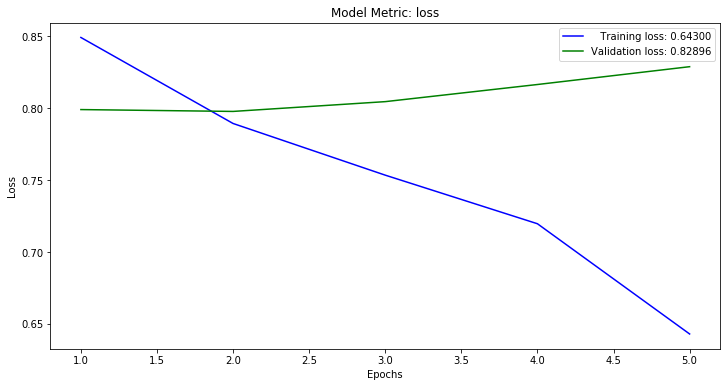

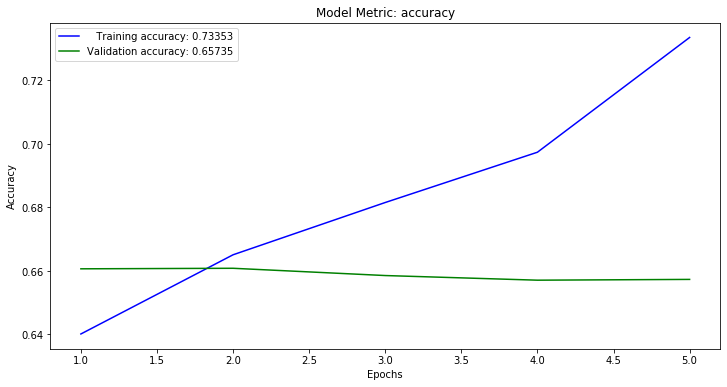

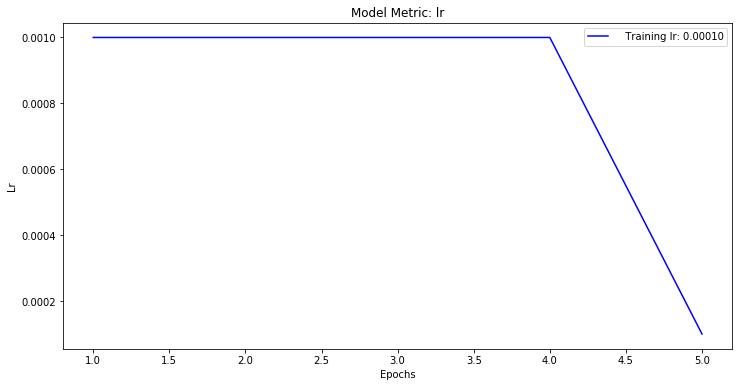

In [67]:
# Plot Model
plot_keras_history(self_trained_model_cnn_history)

In [68]:
print(self_trained_model_cnn.summary())

Model: "my_model_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 84)]              0         
_________________________________________________________________
text_embedding_layer (Embedd (None, 84, 300)           10030200  
_________________________________________________________________
1st_dense_hidden_layer (Conv (None, 82, 64)            57664     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 5)                 325       
Total params: 10,088,189
Trainable params: 10,088,189
Non-trainable params: 0
__________________________________________

In [70]:
# Save Model
self_trained_model_cnn.save(os.path.join(os.getcwd(), 'Self_Trained_Model_CNN'))

In [26]:
# Calculate the predicted y on the X test
y_pred_my_model_cnn = self_trained_model_cnn.predict(X_test)

In [28]:
round(mean_absolute_error(Y_test, y_pred_my_model_cnn),3)

0.179

In [32]:
round(sqrt(mean_squared_error(Y_test, y_pred_my_model_cnn)),3)

0.298

In [27]:
# We will use the accuracy on the Test set to select the best model
accuracy_test_mymodel_cnn = self_trained_model_cnn.evaluate(X_test, Y_test)

6337/6337 [==============================] - 52s 8ms/step - loss: 0.8008 - accuracy: 0.6592


In [29]:
# Table of the Confusion Matrix
class_names=['1', '2', '3', '4', '5']
conf_mat = confusion_matrix(Y_test.argmax(axis=1),y_pred_my_model_cnn.argmax(axis=1))
conf_matrix_mymodel_cnn=pd.DataFrame(conf_mat, columns=class_names,index=class_names)
conf_matrix_mymodel_cnn

,1,2,3,4,5
1,17716,3497,877,519,712
2,4995,5603,3211,1462,784
3,1784,3328,7029,7850,2587
4,504,682,3236,21453,19437
5,558,224,746,12107,81858


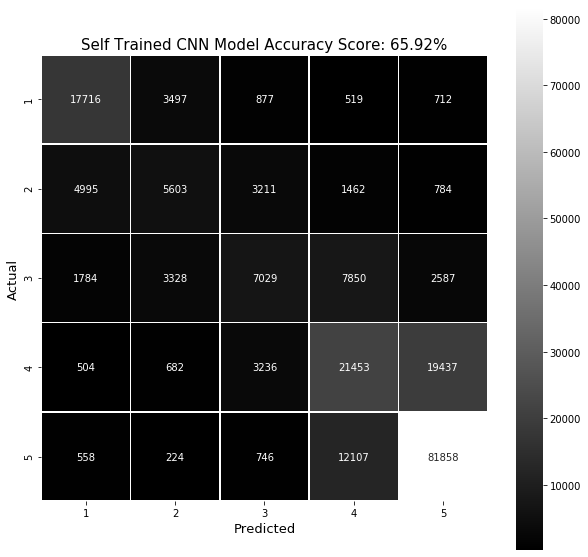

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_matrix_mymodel_cnn, annot=True, fmt='d',linewidths=.5, cmap="gist_gray", square = True,
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual', size = 13)
plt.xlabel('Predicted', size = 13)
all_sample_title = 'Self Trained CNN Model Accuracy Score: 65.92%'
plt.title(all_sample_title, size = 15);
#plt.savefig("mymodel_cnn_conf_matrix.png")
plt.show()

In [76]:
# Create the Classification Report
print("Classification report for Self Trained CNN Model classifier : ")
print(classification_report(Y_test.argmax(axis=1), y_pred_my_model_cnn.argmax(axis=1), target_names=class_names))

Classification report for Self Trained CNN Model classifier : 
              precision    recall  f1-score   support

           1       0.69      0.76      0.72     23321
           2       0.42      0.35      0.38     16055
           3       0.47      0.31      0.37     22578
           4       0.49      0.47      0.48     45312
           5       0.78      0.86      0.82     95493

    accuracy                           0.66    202759
   macro avg       0.57      0.55      0.56    202759
weighted avg       0.64      0.66      0.65    202759



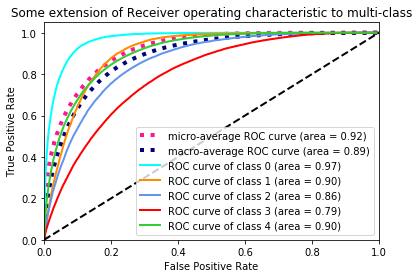

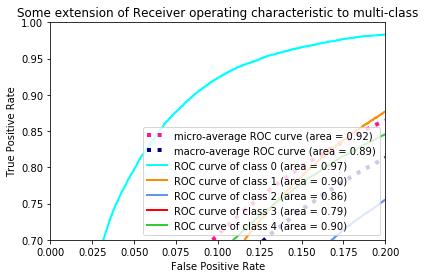

In [77]:
# Plot the ROC Curves in order to calculate the Area Under the Curve
plot_multi_class_roc_auc_curves(nb_classes=5,
                                y_true=Y_test,
                                y_pred_score=y_pred_my_model_cnn)

* The metrics for our classification models are summarized below: 

Classifier    |  Train Acc  |  Train Loss  |    Val Acc   |   Val Loss  |   Test Acc   |  Test Loss  |Weigh Avg F1|    RMSE    
------------- | ----------  | ----------   |  ----------  | ----------  |  ----------  | ----------  | ---------- | ----------
Glove CNN     |    69.39%   |    0.7194    |     66.24%   |    0.8052   |    65.73%    |     0.8052  |     0.63   |     0.299
FastText      |    63.47%   |    0.8680    |     61.74%   |    0.9122   |    61.51%    |     0.9150  |     0.59   |     0.314
Self-Trained  |    69.27%   |    0.7458    |     65.41%   |    0.8294   |    65.24%    |     0.8298  |     0.64   |     0.300
Self-Train CNN|    73.35%   |    0.6340    |     65.73%   |    0.8290   |    65.92%    |     0.8008  |     0.65   |     0.298

* Finally, taking into consideration all the above metrics and plots, we choose the CNN with Self-Trained embeddings as the best model, because it achieves better train-validation and test accuracy and enough smaller loss. Apart from, this model has the highest weighted average F1-score, as well as the lowest Root Mean Square Error.
* When it comes to ROC curves, the Glove CNN and the Self-Trained CNN models have similar behavior and metrics. So, we consider the accuracy, loss and F1 and RMSE scores in order to select the best model.